Playground
---

List of regressors and their hyperparameters

## Linear Regressors
in `sklearn.linear_model`

#### `LinearRegression`
 * Force positive coefficients (e.g. Ordinary least squares vs. Non-Negative least squares): `positive=True`

#### `Ridge`
 * Complexity parameter $\alpha$: `alpha=.5` (defaults to 1.0)
 * Force positive coefficients: `positive=True`
 * Solver method: `solver =` ` 'auto'`, `'svd'`, `'cholesky'`, `'lsqr'`, `'sparse_cg'`, `'sag'`, `'saga'` or `'lbfgs'`

#### `RidgeCV`
 * Same as above with built-in cross validation: defaults to "leave-one-out", `cv=10` triggers 10-fold `GridSearchCV` 
 
#### `Lasso`
 * Sparsity parameter $\alpha$: `alpha=.1` (defaults to 1.0)
 * Force positive coefficients: `positive=True`


#### `LassoCV`
 * Same as above with built-in cross validation: default 5-fold cross-validation, `cv=10` triggers 10-fold `GridSearchCV` 
 
#### `LassoLars`
 * Lasso with Least Angle Regression 

#### `LassoLarsCV`
 * Same as above with built-in cross validation: default 5-fold cross-validation, `cv=10` triggers 10-fold `GridSearchCV` 
 
#### `LassoLarsIC`
* `Lasso` with information-criteria based model selection

#### `MultiTaskLasso`
* `Lasso` with y being a 2D array, of shape (n_samples, n_tasks)

#### `ElasticNet` & `ElasticNetCV`
* ...

#### `MultiTaskElasticNet` & `MultiTaskElasticNetCV`
* ...
* `ElasticNet` with y being a 2D array, of shape (n_samples, n_tasks)

#### `OrthogonalMatchingPursuit`
* ...

#### `BayesianRidge`
* ...

#### `ARDRegression` (Automatic Relevance Determination)
* ...

#### `TweedieRegressor` (GenLins)
* `power`, `alpha`, `link=` z.B. `'log'`
* `power = 1` equivalent to `PoissonRegressor`
* `power = 2` equivalent to `GammaRegressor`
* `power = 3` Inverse Gaussian distribution.

#### `SGDRegressor`
* ...

#### `Perceptron`
* ...

#### `PassiveAggressiveRegressor`
* ...

#### `HuberRegressor` & `TheilSenRegressor` & `RANSACRegressor`
* ...

#### `QuantileRegressor`
* ...

#### `PolynomialFeatures`
* ...

**Implement XGBRegressor?**

```python
from xgboost import XGBRegressor
```

In [209]:
from sklearn.model_selection import GroupShuffleSplit
from skopt import BayesSearchCV
from get_data import get_mindfulness as get_data
from regressors import get_regressor
from utils import split_train_test
from skopt.plots import plot_objective, plot_evaluations, plot_convergence
import matplotlib.pyplot as plt



X, y = get_data("ffmq-overall")

reg_type = "rf"
# for reg_type in ["elasticnet", "rf", "extratrees", "gradientboost"]:

# "elasticnet", "rf", "extratrees", "gradientboost"
reg, hyperparams_dist = get_regressor(reg_type)

outer_cv = GroupShuffleSplit(n_splits=5,
                             test_size=0.2,
                             random_state=0
                             )

# iterate over outer CV splitter
for i_cv, (i_train, i_test) in enumerate(outer_cv.split(X, y, groups=X.index), start=1):

    y_train, y_test = split_train_test(y, i_train, i_test)
    X_train, X_test = split_train_test(X, i_train, i_test)

    # nested CV with parameter optimization
    search_reg = BayesSearchCV(
        estimator=reg,
        search_spaces=hyperparams_dist,
        n_iter=200,  # 200
        cv=5,
        n_jobs=8,
        random_state=0
    )

    result = search_reg.fit(X_train, y_train.values.ravel())

    print(f"Split {i_cv}:", result.best_estimator_)
    print("train score:", round(result.score(X_train, y_train), 5))
    print("test  score:", round(result.score(X_test, y_test), 5))
    print("\n")

/home/user/miniconda3/envs/ml/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/user/miniconda3/envs/ml/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/user/miniconda3/envs/ml/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/user/miniconda3/envs/ml/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/user/miniconda3/envs/ml/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point 

KeyboardInterrupt: 

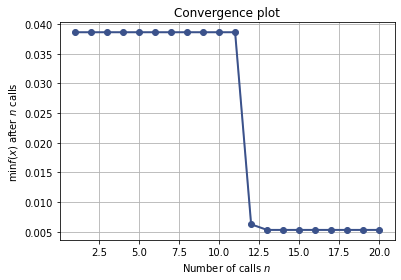

In [203]:
plot_convergence(search_reg.optimizer_results_)
plt.savefig("plot_convergence_"+reg_type+".png")

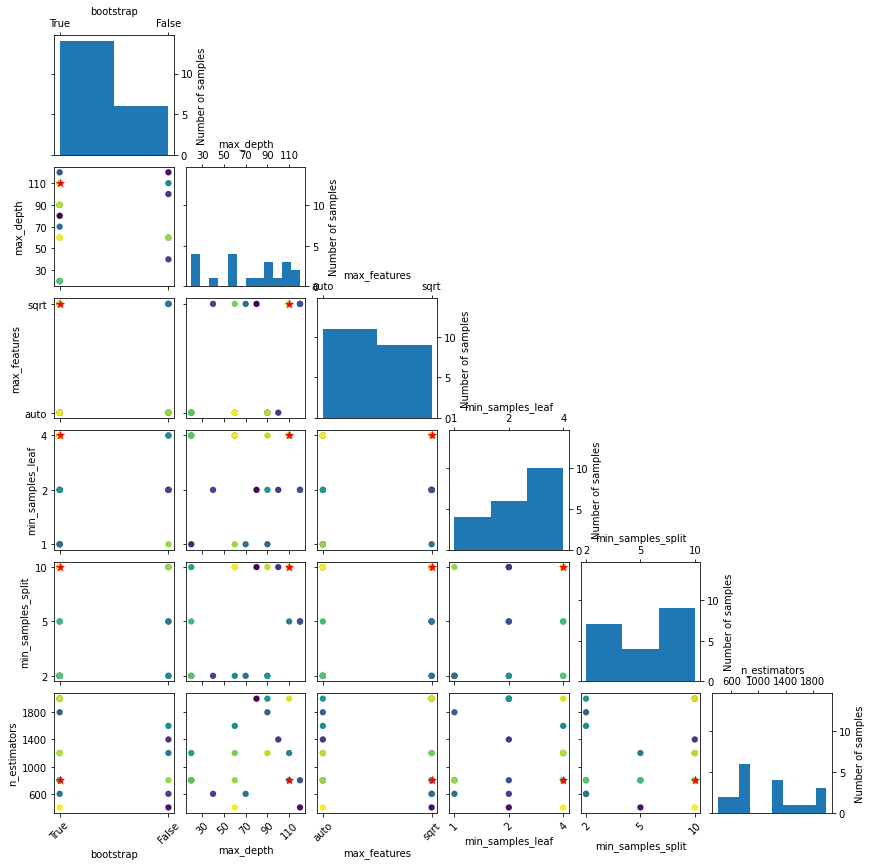

In [204]:
plot_evaluations(search_reg.optimizer_results_[0])
plt.savefig("plot_evaluations_"+reg_type+".png")

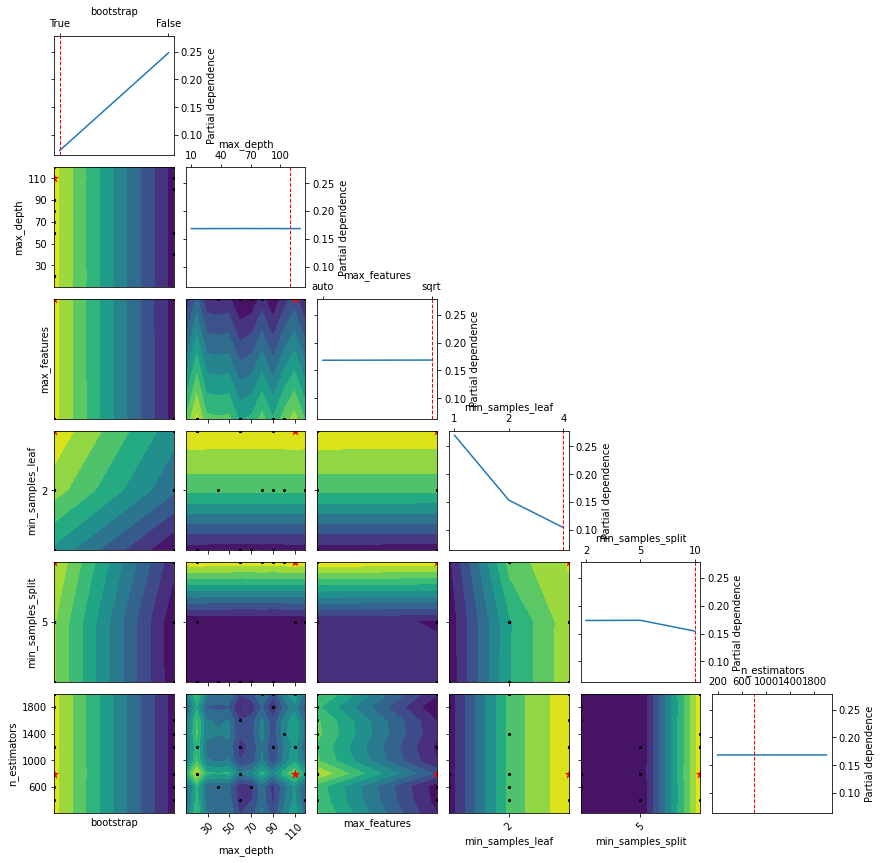

In [205]:
plot_objective(search_reg.optimizer_results_[0])
plt.savefig("plot_objective_"+reg_type+".png")

predict

/tmp/ipykernel_119266/2817769444.py:15: RuntimeWarning: invalid value encountered in double_scalars
  plt.text(0.4, 22, f"Best score $R²$ = {result.best_score_.round(3)} ($r$ = {(result.best_score_.round(3)**(1/2)).round(2)})", fontsize=12)


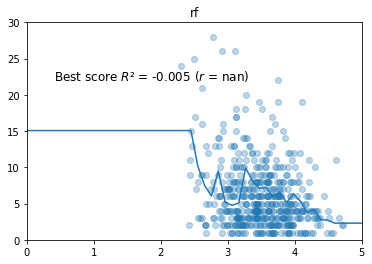

In [208]:
import numpy as np
import pandas as pd

y_pred = result.best_estimator_.predict(X)

fig, ax = plt.subplots()
ax.scatter(X,y,alpha=0.3)
x = pd.DataFrame(np.linspace(0,5),columns=X.columns)
ax.plot(x.values,result.best_estimator_.predict(x))
ax.title.set_text(reg_type)
try:
    plt.text(0.4, 25, f"y = {result.best_estimator_.coef_[0].round(2)}x + {result.best_estimator_.intercept_.round(2)}", fontsize=12)
except:
    ...
plt.text(0.4, 22, f"Best score $R²$ = {result.best_score_.round(3)} ($r$ = {(result.best_score_.round(3)**(1/2)).round(2)})", fontsize=12)
ax.set_ylim(0,30)
ax.set_xlim(0,5)
fig.savefig("predictions_"+reg_type+".png")